In [1]:
# Imports

import numpy
import pandas
import matplotlib.pyplot as pplot
from tensorflow import keras
from keras import layers, Model
from PIL import Image

IMAGE_SIZE = (1024, 1024)

In [2]:
# Load an example image

image = Image.open('./ISIC_0000000.jpg')
image = image.resize(IMAGE_SIZE)
label_image = Image.open('./ISIC_0000000_segmentation.png')
label_image = label_image.resize(IMAGE_SIZE)

FileNotFoundError: ignored

In [ ]:
# Convert to numpy

input_data = numpy.array(image.getdata(), dtype='float64').reshape(1, 1024, 1024, 3)
label_data = numpy.array(label_image.getdata(), dtype='float64').reshape(1, 1024, 1024, 1) / 255

print(f'Shape of input image: {input_data.shape}')
print(f'Shape of label image: {label_data.shape}')

In [ ]:
# Full U-Net Model

def encoder_block(inputs, n_filters, max_pooling=True):
    conv = layers.Conv2D(n_filters, kernel_size=3, activation='relu', padding='same')(inputs)
    conv = layers.Conv2D(n_filters, kernel_size=3, activation='relu', padding='same')(conv)
    skip_connection = conv
    if max_pooling:
        conv = layers.MaxPool2D(pool_size=(2, 2), strides=2, padding='same')(conv)
    return conv, skip_connection

def decoder_block(inputs, n_filters, skip_connection):
    conv = layers.UpSampling2D(size=(2, 2))(inputs)
    _, new_width, new_height, _ = conv.shape
    new_skip = layers.CenterCrop(new_width, new_height)(skip_connection)
    conv = layers.Concatenate(axis=3)([conv, new_skip])
    conv = layers.Conv2DTranspose(n_filters, kernel_size=3, activation='relu', padding='same')(conv)
    conv = layers.Conv2DTranspose(n_filters, kernel_size=3, activation='relu', padding='same')(conv)
    return conv

def init_encoder(inputs):
    e_block_1, skip_1 = encoder_block(inputs, 64)
    e_block_2, skip_2 = encoder_block(e_block_1, 128)
    e_block_3, skip_3 = encoder_block(e_block_2, 256)
    e_block_4, skip_4 = encoder_block(e_block_3, 512)
    e_block_5, _ = encoder_block(e_block_4, 1024, max_pooling=False)
    return (e_block_5, skip_1, skip_2, skip_3, skip_4)

def init_decoder(inputs, skip_1, skip_2, skip_3, skip_4):
    d_block_1 = decoder_block(inputs, 512, skip_4)
    d_block_2 = decoder_block(d_block_1, 256, skip_3)
    d_block_3 = decoder_block(d_block_2, 128, skip_2)
    d_block_4 = decoder_block(d_block_3, 64, skip_1)
    outputs = layers.Conv2D(2, kernel_size=3, activation='softmax', padding='same')(d_block_4)
    return outputs

def init_model(input_shape):
    inputs = layers.Input(shape=input_shape)
    outputs, skip_1, skip_2, skip_3, skip_4 = init_encoder(inputs)
    outputs = init_decoder(outputs, skip_1, skip_2, skip_3, skip_4)
    model = Model(inputs, outputs)
    model.compile(
        optimizer='adam',
        loss='binary_cross_entropy'
    )
    return model

In [31]:
# Simple U-Net Model

def encoder_block_2(inputs, n_filters, max_pooling=True):
    conv = layers.Conv2D(n_filters, kernel_size=3, activation='relu', padding='same')(inputs)
    skip_connection = conv
    if max_pooling:
        conv = layers.MaxPool2D(pool_size=(2, 2), strides=2, padding='same')(conv)
    return conv, skip_connection

def decoder_block_2(inputs, n_filters, skip_connection):
    conv = layers.UpSampling2D(size=(2, 2))(inputs)
    _, new_width, new_height, _ = conv.shape
    new_skip = layers.CenterCrop(new_width, new_height)(skip_connection)
    conv = layers.Concatenate(axis=3)([conv, new_skip])
    conv = layers.Conv2DTranspose(n_filters, kernel_size=3, activation='relu', padding='same')(conv)
    return conv

def init_encoder_2(inputs):
    e_block_1, skip_1 = encoder_block_2(inputs, 64)
    e_block_2, skip_2 = encoder_block_2(e_block_1, 128)
    e_block_3, skip_3 = encoder_block_2(e_block_2, 256)
    outputs, _ = encoder_block_2(e_block_3, 512, max_pooling=False)
    return (outputs, skip_1, skip_2, skip_3)

def init_decoder_2(inputs, skip_1, skip_2, skip_3):
    d_block_2 = decoder_block_2(inputs, 256, skip_3)
    d_block_3 = decoder_block_2(d_block_2, 128, skip_2)
    d_block_4 = decoder_block_2(d_block_3, 64, skip_1)
    outputs = layers.Conv2D(1, kernel_size=3, activation='sigmoid', padding='same')(d_block_4)
    return outputs

def init_model_2(input_shape):
    inputs = layers.Input(shape=input_shape)
    outputs, skip_1, skip_2, skip_3 = init_encoder_2(inputs)
    outputs = init_decoder_2(outputs, skip_1, skip_2, skip_3)
    model = Model(inputs, outputs)
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy'
    )
    return model

In [32]:
model = init_model_2(input_data.shape[1:])
print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 1024, 1024, 3)]      0         []                            
                                                                                                  
 conv2d_10 (Conv2D)          (None, 1024, 1024, 64)       1792      ['input_11[0][0]']            
                                                                                                  
 max_pooling2d_6 (MaxPoolin  (None, 512, 512, 64)         0         ['conv2d_10[0][0]']           
 g2D)                                                                                             
                                                                                                  
 conv2d_11 (Conv2D)          (None, 512, 512, 128)        73856     ['max_pooling2d_6[0][0]'

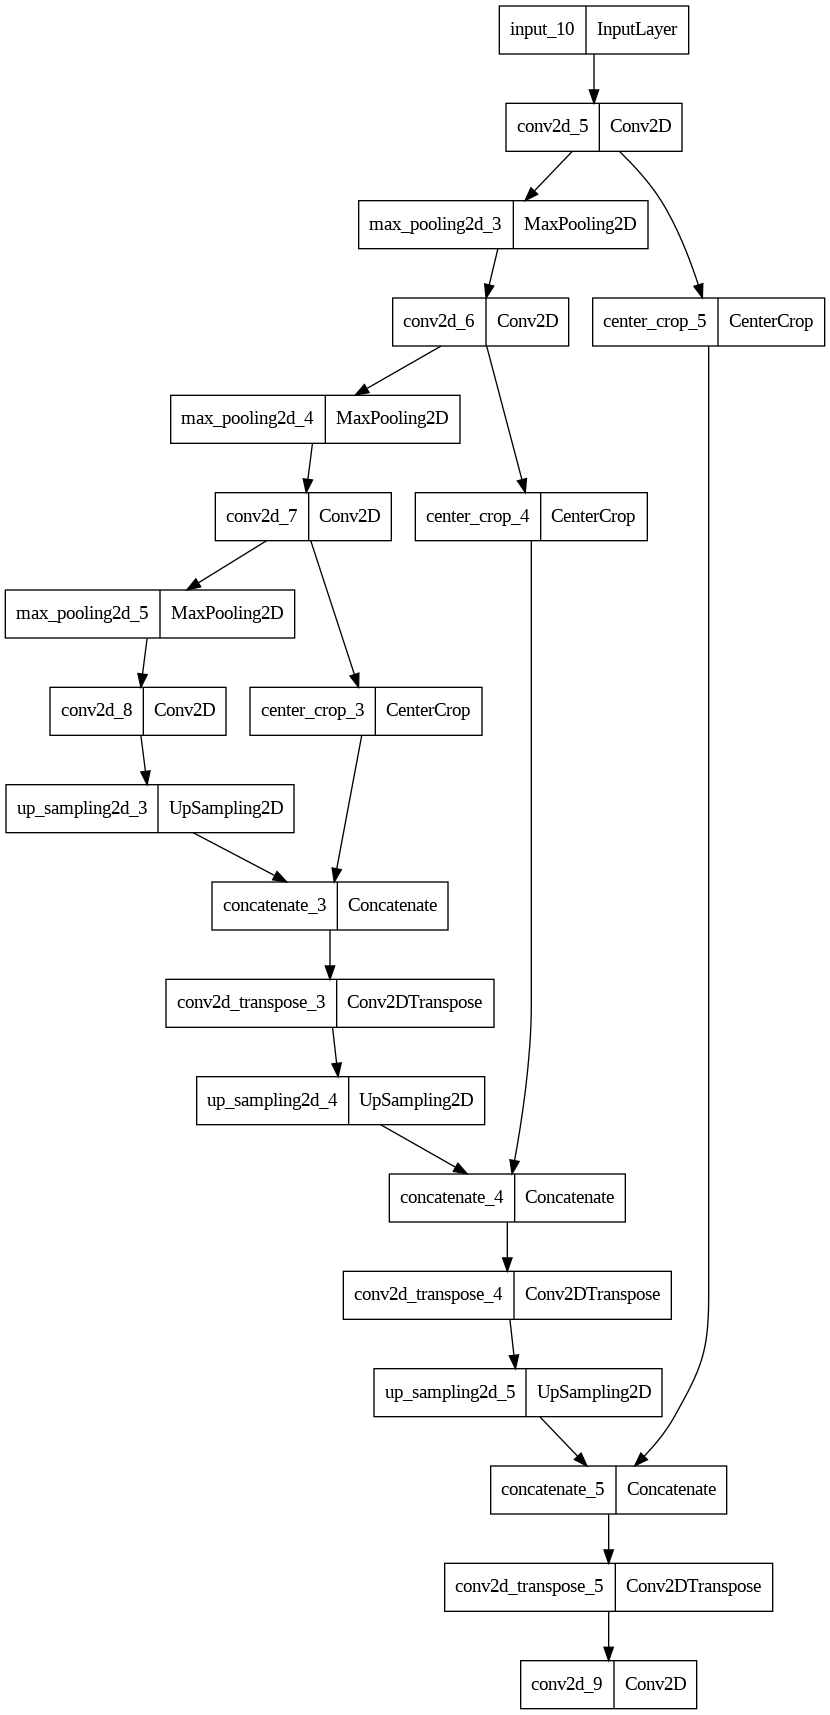

In [22]:
keras.utils.plot_model(model)

In [34]:
model.fit(input_data, label_data, epochs=10)

Epoch 1/10
1/1 [==============================] - 53s 53s/step - loss: 91.0358
Epoch 2/10
1/1 [==============================] - 51s 51s/step - loss: 7.4969
Epoch 3/10
1/1 [==============================] - 51s 51s/step - loss: 69.7136
Epoch 4/10


KeyboardInterrupt: ignored